In [53]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy.io
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec

In [2]:


meas_type = 3

if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_90RAAN.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['truth_pos_vel']
true_density_array = mydict2['true_density']*1e9
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))

#convert to km
truth_xyz = truth_xyz * 1e-3
measurement_array[:, -1] = measurement_array[:, -1] * 1e-3


#"""
measurement_array = measurement_array[24:,:]
truth_xyz = truth_xyz[24:, :]
true_density_array = true_density_array[24:]
lat_lst_meas_array = lat_lst_meas_array[24:, :]
#"""


#sample measurements so only using every nth measurement
"""
truth_xyz = truth_xyz[0::20]
measurement_array = measurement_array[0::20]
true_density_array = true_density_array[0::20]
lat_lst_meas_array = lat_lst_meas_array[0::20]
print(measurement_array[50,0]/(60))
"""



(407, 5)
(407, 6)


'\ntruth_xyz = truth_xyz[0::20]\nmeasurement_array = measurement_array[0::20]\ntrue_density_array = true_density_array[0::20]\nlat_lst_meas_array = lat_lst_meas_array[0::20]\nprint(measurement_array[50,0]/(60))\n'

In [3]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4#1e-9 #1e-4****
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 


Shape of Vector of State/density Ensembles: (450, 37, 73)
0.000479211906198
0.000481779364255


In [4]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx


In [5]:

#EnKF specific functionality




def gen_ensemble(X_0, Bsqrt_cov, ensemble_size):
    
    X_0 = X_0.reshape(len(X_0), 1)
    
    ensemble = np.zeros((len(X_0), ensemble_size))
    
    for ii in range(ensemble_size):
        
        member = X_0 + np.dot(Bsqrt_cov, np.random.randn(len(X_0), 1))

        ensemble[:, ii] = member.reshape(len(X_0))
    
    return ensemble
    



In [6]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')


two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z

In [7]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp
    


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [8]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [9]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [10]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
X_full = X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot, density])
H_tilde = G.jacobian(X_full)
#print(H_tilde)
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [11]:



def calc_P_TU(X_mean, ensemble):
    
    dimension = len(X_mean)
    
    P_bar_sum = np.zeros((dimension, dimension))
    
    for ii in range(num_of_ensembles):

        X = ensemble[:, ii].reshape(dimension, 1)
        diff_X = X - X_mean
        P_bar_sum = P_bar_sum + np.dot(diff_X, diff_X.T)

    P_bar = P_bar_sum/(num_of_ensembles-1)

    return P_bar



In [12]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6
fullState_dimension = prob_dimension + density_dimension

X_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2] \
            + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation, \
            truth_xyz[0,5] + vel_perturbation])

                  
P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2, (1e-4)**2]) #(1e-4)**2


(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_RV_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_ensembles)
print(np.shape(X_RV_ensemble))


#for process noise
snc_sigma = 1e-5

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])


#reduced rank variable for number of eigvals
q = 39

    
print(X_ref)

(6, 450)
[ -3.880841946703775e+03   4.386364503820895e+03   3.405379744816038e+03
  -3.904927218294224e+00  -5.846046198407902e+00   3.065073084378303e+00]


In [13]:

#Determine value for q (number of eigenvalues/vecs to keep)

"""

dens_ens = ensembles_of_density_grid.reshape(num_of_ensembles, density_dimension).T

X_density_ensemble = np.zeros((fullState_dimension, num_of_ensembles))
X_density_ensemble[:6, :] = X_RV_ensemble
X_density_ensemble[6:, :] = dens_ens


#mean of X state & density state over ensemble
X_bar = np.sum(X_density_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles

#calculate Time Updated P
P_TU = calc_P_TU(X_bar, X_density_ensemble)


eigvals, eigvecs = np.linalg.eig(P_TU)

np.shape(eigvecs)


#filename = 'Data Files/Covariance.mat'
#scipy.io.savemat(filename, mdict={'P_bar': P_TU})

indices = np.where(eigvals > 1e-2)[0]
print(np.shape(indices))
#print(indices)

indices = np.where(eigvals > 1e-7)[0]
print(np.shape(indices))
#print(indices)

indices = np.where(eigvals > 1e-8)[0]
print(np.shape(indices))
#print(indices)


eigvec_truncated = eigvecs[:, :449]
eigvals_truncated = eigvals[:449]

L = eigvecs * np.sqrt(eigvals) 

Pppp = np.dot(L, L.T)
#print(np.mean(Pppp - P_TU))


L_tilde = np.append(L, np.ones((2707, 2707))*.5e-1).reshape(2707, 2707+2707)

eigvalss, eigvecss = np.linalg.eig(np.dot(L_tilde, L_tilde.T))
PI = eigvecss[:,:q]

print(np.shape(L_tilde))
print(np.shape(PI))


"""

"\n\ndens_ens = ensembles_of_density_grid.reshape(num_of_ensembles, density_dimension).T\n\nX_density_ensemble = np.zeros((fullState_dimension, num_of_ensembles))\nX_density_ensemble[:6, :] = X_RV_ensemble\nX_density_ensemble[6:, :] = dens_ens\n\n\n#mean of X state & density state over ensemble\nX_bar = np.sum(X_density_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles\n\n#calculate Time Updated P\nP_TU = calc_P_TU(X_bar, X_density_ensemble)\n\n\neigvals, eigvecs = np.linalg.eig(P_TU)\n\nnp.shape(eigvecs)\n\n\n#filename = 'Data Files/Covariance.mat'\n#scipy.io.savemat(filename, mdict={'P_bar': P_TU})\n\nindices = np.where(eigvals > 1e-2)[0]\nprint(np.shape(indices))\n#print(indices)\n\nindices = np.where(eigvals > 1e-7)[0]\nprint(np.shape(indices))\n#print(indices)\n\nindices = np.where(eigvals > 1e-8)[0]\nprint(np.shape(indices))\n#print(indices)\n\n\neigvec_truncated = eigvecs[:, :449]\neigvals_truncated = eigvals[:449]\n\nL = eigvecs * np.sqrt(eigvals) \n\nPppp = np.

In [14]:
#np.all(np.linalg.eigvals(P_TU) > 0) # but all real

In [15]:
#KALMAN

def execute_enkf(obs_data, X_RV_ensemble, P, R, X_density_ensemble,\
                         prob_dimension, density_dimension, stop_index):
    
    #initializations
    Q_ECI = np.zeros((6,6))
    
    num_of_meas = np.shape(R)[0]
    X_7elem_mean_updated = np.sum(X_RV_ensemble, axis=1)/num_of_ensembles

    pre_fit_list = np.zeros((stop_index, num_of_meas))
    prefit_bounds_list = np.zeros((stop_index, num_of_meas))
    post_fit_list = np.zeros((stop_index, num_of_meas))

    P_list = np.zeros((stop_index, prob_dimension+1, prob_dimension+1))
    #P_full_list = np.zeros((21, fullState_dimension, fullState_dimension))
    X_7elem_mean_updated_list = np.zeros((stop_index, prob_dimension+1))
    
    density_MSIS_array = np.zeros(stop_index)
    #est_density_grid_array = np.zeros((stop_index, num_of_lat, num_of_lon))

    
    X_distribution = np.zeros((prob_dimension, num_of_ensembles, stop_index))
    density_distribution = np.zeros((num_of_ensembles, stop_index))
    lat_lst_array = np.zeros((2, stop_index))
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))

    
    #for Reduced Rank
    dens_ens = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))
    X_ensemble[:6, :] = X_RV_ensemble
    X_ensemble[6:, :] = dens_ens

    #mean of X state & density state over ensemble
    X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
    P = calc_P_TU(X_mean, X_ensemble)
    
    eigvals, eigvecs = np.linalg.eig(P)
    eigvec_truncated = eigvecs[:, :q]
    eigvals_truncated = eigvals[:q]
    L = np.dot(eigvec_truncated, np.diag(np.sqrt(eigvals_truncated)))
    
    P_counter = 0
    
    
    time = obs_data[0, 0]
    obsnum = 0
    
    
    while time < obs_data[stop_index,0]:
    #for obsnum in range(len(obs_data[:stop_index])):
    

        #Tracer() ()
        t_init = time - 10 
        if obsnum == 0:
            t_init = time
            
        
        
        
        #determine density to be used in propagation
        (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[:3,0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
        
        
        #reduced rank
        epsilon = .95 #number close to 1
        X_mean_wSigma_array = np.tile(X_mean, q) + epsilon*L
        
        
        
        densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        result = X_RV_ensemble

        if (obsnum != 0):
            
            #print(time)
            result = np.zeros((prob_dimension, num_of_ensembles))

            for ii in range(num_of_ensembles):
                #set the initial values for the propogator:
                y0 = X_RV_ensemble[:, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[:, ii] = integrator.y

        X_RV_ensemble = result.reshape(prob_dimension, num_of_ensembles)
        
        
        #create array that holds X state ensemble & density state ensemble combined
        density_state = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        X_ensemble[:6, :] = X_RV_ensemble
        X_ensemble[6:, :] = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T 
        
        
        
        #reduced rank
        result = X_mean_wSigma_array[:6,:]
        result_mean = X_mean[:6]
        if (obsnum != 0):
            
            result = np.zeros((prob_dimension, q))

            for ii in range(q):
                y0 = X_mean_wSigma_array[:6, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[:, ii] = integrator.y
                
                
            y0 = X_mean[:6]
            density = densities[ii]

            integrator = ode(orbitpropogator_EnKF)
            integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
            integrator.set_f_params(density)
            integrator.set_initial_value(y0, t_init)
            integrator.integrate(time)
            result_mean = integrator.y    
            
        
        X_mean_wSigma_array_TU = np.zeros((fullState_dimension, q))
        X_mean_wSigma_array_TU[:6,:] = result.reshape(prob_dimension, q)
        X_mean_wSigma_array_TU[6:,:] = X_mean_wSigma_array[6:,:]
        
        X_mean_TU = np.zeros((fullState_dimension, 1))
        X_mean_TU[:6, 0] = result_mean.reshape(prob_dimension)
        X_mean_TU[6:, 0] = X_mean[6:].reshape(density_dimension)

        L = (1/epsilon) * (X_mean_wSigma_array_TU - np.tile(X_mean_TU, q))
        
        
        #Use SNC P_bar if delta t is less than 100 seconds---------------------------
        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            delta_t = obs_data[obsnum, 0] - obs_data[obsnum-1, 0]
            if obsnum == 0:
                delta_t = 0
            if (delta_t < 15 and snc_flag):
                #build SNC STM
                idenity_6_3 = np.array([(delta_t/2)*np.eye(3), np.eye(3)]).reshape(6, 3)
                snc_stm = delta_t*idenity_6_3
                #Covariance with SNC: Q Matrix
                Q = np.identity(3)*(snc_sigma)**2

                #Q_entire = np.zeros((fullState_dimension, fullState_dimension))
                #Q_entire[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                #instead:
                FQ = np.zeros((fullState_dimension, prob_dimension))
                FQ[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                
                #build density portion of Q
                #Q_entire[prob_dimension:, prob_dimension:] = np.eye(density_dimension, density_dimension) * 1e-9
                
                #Eq. 24:
                L_tilde = np.zeros((fullState_dimension, q+prob_dimension))
                L_tilde[:, :q] = L
                L_tilde[:, q:] = FQ #Q_entire
                
                #Eq. 25:
                eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde)) 
                L = np.dot(L_tilde, X)[:, :q]
                

        #Tracer() ()       
        #mean of X state & density state over ensemble, reduced rank, *re-definition of X_mean on purpose*
        X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles #Eq. 16
        E = X_ensemble - np.tile(X_mean, num_of_ensembles) #Eq. 17
        
        
        #-------------------Measurement Update--------------------------------------------------------
        
        
        indices = np.where(obs_data[:,0] == time)[0]
        for ii in range(len(indices)):
            obsnum = indices[ii]
            print(time, obsnum)
        
        
            #determine station coordinates for observation eq.
            if int(obs_data[obsnum, 1]) == 1:
                #print('1')
                station_index = 0
                X_s = r_ecef_dss34
            if int(obs_data[obsnum, 1]) == 2:
                #print('2')
                station_index = 1
                X_s = r_ecef_dss65
            if int(obs_data[obsnum, 1]) == 3:
                #print('3')
                station_index = 2
                X_s = r_ecef_dss13
            if int(obs_data[obsnum, 1]) == 4:
                #print('amos')
                station_index = 3
                X_s = r_ecef_diego




            #Tracer() ()
            #assuming Eq. 31 is supposed to be ensemble - x_mean, not just ensemble
            #below is the alternative to Eq. 32 (determined by Penny & I)
            EtransposeE = np.dot(E.T, E)
            eigvals, X = np.linalg.eig(EtransposeE)
            E_perp = np.dot(E, X)[:,q:] #Eq. 32 alternative

            E_doublePrime = np.dot(E, X)[:,:q] #Eq. 35 alternative

            lambdaa = .1 #.2
            P = lambdaa * np.dot(L, L.T) + ((1-lambdaa)/(num_of_ensembles-1)) * np.dot(E_doublePrime, E_doublePrime.T) \
                                    + (1/(num_of_ensembles-1)) * np.dot(E_perp, E_perp.T) #Eq. 37



            H = np.zeros((num_of_meas, fullState_dimension))
            H[:num_of_meas, :prob_dimension+1] = H_tilde_sol_fcn(*X_mean[:6,0], *X_s, time)

            part1 = np.dot(P, H.T)
            part2 = np.dot(H, np.dot(P, H.T))
            K = np.dot(part1, np.linalg.inv(part2 + R)) #Eq. 34

            #computations needed for Eq. 20
            Hx_array = np.zeros((num_of_meas, num_of_ensembles))
            Hx = np.zeros(3)
            for ii in range(num_of_ensembles):

                X = X_RV_ensemble[:, ii]
                Hx = G_sol_fcn(*X, *X_s, time)

                if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                    Hx[0] = Hx[0] + 2*math.pi

                Hx_array[:, ii] = Hx.reshape(num_of_meas)

            #Tracer() ()
            #get actual observation
            y_observed = obs_data[obsnum, 2:(2+num_of_meas)].reshape(num_of_meas,1)

            #Eq. 20:
            X_ensemble_updated = np.zeros((fullState_dimension, num_of_ensembles))
            for ii in range(num_of_ensembles):

                e = np.sqrt(np.diag(R)).reshape(num_of_meas, 1) * np.random.randn(num_of_meas, 1)

                correction = np.dot(K, (y_observed + e - Hx_array[:, ii].reshape(num_of_meas, 1)))

                X_member_updated = X_ensemble[:, ii].reshape(fullState_dimension, 1) + correction

                X_ensemble_updated[:, ii] = X_member_updated.reshape(fullState_dimension)



            #update overall density grid ensemble with this lat/lon's updated density values 
            X_density_ensemble = copy.deepcopy(X_ensemble_updated[6:,:].T.reshape(num_of_ensembles, \
                                                                                            num_of_lat, num_of_lon)) 
            X_ensemble = copy.deepcopy(X_ensemble_updated)
            #est_density_grid_array[obsnum] = np.mean(X_density_ensemble, axis=0)

            #Tracer() ()
            #SRF Update equations for updating L for next obs time
            #Eq. 28, using X_mean b/c paper shows mean being propagated then used, not
            #ensemble being propagated and then the mean calculated and used
            Hx = G_sol_fcn(*X_mean[:6,0], *X_s, time)
            X_mean_MU = X_mean + np.dot(K, y - Hx) #not used? Eq. 28


            #Eq. 29:
            H = np.zeros((num_of_meas, fullState_dimension))
            H[:num_of_meas, :prob_dimension+1] = H_tilde_sol_fcn(*X_mean[:6,0], *X_s, time)

            L_tilde = np.zeros((fullState_dimension, q+num_of_meas))
            part1 = np.eye(fullState_dimension, fullState_dimension) - np.dot(K, H)
            L_tilde[:, :q] = np.dot(part1, L)
            L_tilde[:, q:] = np.dot(K, np.sqrt(R)) #Eq. 29

            #Eq. 30
            eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde))
            L = np.dot(L_tilde, X)[:, :q]




            #save values
            X_7elem_mean_updated = np.zeros((7))
            X_7elem_mean_updated[:6] = np.sum(X_ensemble_updated[:6,:], axis=1)/num_of_ensembles
            X_7elem_mean_updated[6:] = np.sum(X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                                /num_of_ensembles
            X_7elem_mean_updated_list[obsnum, :] = X_7elem_mean_updated

            #save values for analysis of distributions and such
            density_distribution[:, obsnum] = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks] 
            X_distribution[:, :, obsnum] = X_ensemble_updated[:6, :]
            lat_lst_array[:, obsnum] = np.array([latitude_grid[lat_grid_ticks], longitude_grid[lst_grid_ticks]]).reshape(2)




            P_list[obsnum, :6, :6] = P[:6, :6]
            P_list[obsnum, -1, -1] = P[0,6:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]

            #if ((obsnum == 0) or (obsnum % 10 == 0) or (obsnum == 199)):
                #P_full_list[P_counter, :, :] = P
                #P_counter = P_counter + 1


            #-------------RMS / Residuals-------------
            Hx = G_sol_fcn(*X_7elem_mean_updated[:6], *X_s, time)
            if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                Hx[0] = Hx[0] + 2*math.pi
            post_fit_resid = y_observed - Hx.reshape(num_of_meas, 1)
            post_fit_list[obsnum, :] = post_fit_resid.reshape(num_of_meas) 


            #pre-fit residual calculation
            #determine observation as evaluated in observation equation with ref. 
            y_G_ref = G_sol_fcn(*X_mean[:6,0], *X_s, time)
            if (meas_type != 1) and (y_G_ref[0] < 0): #if az less than 0, add 2*pi
                    y_G_ref[0] = y_G_ref[0] + 2*math.pi

            #get actual observation
            y_observed = obs_data[obsnum, 2:(2+num_of_meas)].reshape(num_of_meas,1)

            #calculate pre-fit
            prefit_bounds = np.sqrt(np.dot(H, np.dot(P, H.T)) + R)
            prefit_bounds_list[obsnum, :] = np.diag(prefit_bounds)
            prefit = y_observed - y_G_ref
            pre_fit_list[obsnum, :] = prefit.reshape(num_of_meas)


            #Prep for next time step
            X_RV_ensemble = X_ensemble_updated[:6, :]
            
            X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
            
            
            #save true MSIS density for this time step (which is density at beginning of time used to prop for this step)
            density_MSIS = filter_functions.calc_MSIS_density(time, X_7elem_mean_updated, day_of_year_init, day_of_month_init, \
                                                    hour_init_UT, month_init, year_init, omega_const, r_earth_const)
            density_MSIS = density_MSIS * 1e9  #convert from kg/m**3 to kg/km**3
            density_MSIS_array[obsnum] = density_MSIS

            obsnum = obsnum + 1 #just to ensure that obsnum is not still zero for second time
            
        
        time = time + 10


    
    return (X_7elem_mean_updated_list, P_list, pre_fit_list, prefit_bounds_list, post_fit_list, density_MSIS_array, X_distribution, \
            density_distribution, lat_lst_array, X_density_ensemble, X_ensemble)
            
            #, est_density_grid_array)

In [16]:
#Call EnKF

snc_flag = False
stop_index = 150 #558 * 3 #92.56 minutes #/2

(X_mean_updated_list_EnKF, P_list_EnKF, pre_fit_list, prefit_bounds_list, post_fit_list_EnKF, \
 density_MSIS_array, X_distribution, density_distribution, lat_lst_array, density_state_ensemble, \
                     X_ensemble) = \
            execute_enkf(measurement_array, X_RV_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, stop_index)
    
#, est_density_grid_array) = \

34020.0 0
34030.0 1
34040.0 2
34050.0 3
34060.0 4
34070.0 5
34080.0 6
34090.0 7
34100.0 8
34110.0 9
34120.0 10
34130.0 11
34140.0 12
34150.0 13
34160.0 14
34170.0 15
34180.0 16
34190.0 17
34200.0 18
34210.0 19
34220.0 20
34230.0 21
34240.0 22
34250.0 23
34260.0 24
34270.0 25
34280.0 26
34290.0 27
34300.0 28
34310.0 29
34320.0 30
36600.0 31
36610.0 32
36620.0 33
36630.0 34
36640.0 35
36650.0 36
36660.0 37
36670.0 38
36680.0 39
36690.0 40
36700.0 41
36710.0 42
36720.0 43
36730.0 44
36740.0 45
36750.0 46
36760.0 47
36770.0 48
36780.0 49
36790.0 50
36800.0 51
36810.0 52
36820.0 53
36830.0 54
36840.0 55
36850.0 56
36860.0 57
39800.0 58
39810.0 59
39820.0 60
39830.0 61
39840.0 62
39850.0 63
39860.0 64
39870.0 65
39880.0 66
39890.0 67
39900.0 68
39910.0 69
39920.0 70
39930.0 71
39940.0 72
39950.0 73
39960.0 74
39970.0 75
39980.0 76
39990.0 77
40000.0 78
40010.0 79
40020.0 80
40030.0 81
40040.0 82
40050.0 83
40060.0 84
40070.0 85
40080.0 86
40090.0 87
40100.0 88
40110.0 89
40120.0 90
40130.0 9

In [17]:
saveFig_bool = True

save_results = False

#stop_index = 4

In [31]:
#Save Results



saveFig_bool = True

save_results = False

save_density_grid = False #save time series of density grid, True if saved the est. density grid within EnKF

"""

if ((save_density_grid == False) and (save_results)):

    #generate density grid for final time in order to compare entire final density grid estimate to truth
    alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const

    final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                        day_of_year_init, measurement_array[stop_index-1,0]) #final time
   
    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'X_distribution': X_distribution, \#'P_full_list': P_full_list, \
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
        'true_density_array': true_density_array, \
          'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}


    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()


    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, \#'P_full_list': P_full_list, \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})
    

    
    
if (save_density_grid and save_results):

    final_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))    

    for ii in range(stop_index):

        #generate density grid for final time in order to compare entire final density grid estimate to truth
        alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const
        final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                    day_of_year_init, measurement_array[ii,0]) #final time

    #PKL file

    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, \#'P_full_list': P_full_list,  \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
            'true_density_array': true_density_array, \
              'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
             'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()



    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, \#'P_full_list': P_full_list,  \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
            'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})

    """


"\n\nif ((save_density_grid == False) and (save_results)):\n\n    #generate density grid for final time in order to compare entire final density grid estimate to truth\n    alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const\n\n    final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,                                                        day_of_year_init, measurement_array[stop_index-1,0]) #final time\n   \n    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF,           'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array,           'X_distribution': X_distribution, \\#'P_full_list': P_full_list,           'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,\n         'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,        'true_density_array': true_density_array,           'final_density_grid

In [32]:
#Read Data (from saved run) in to Generate Results

"""

# read python dict containing densities
results_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl
mydict = pickle.load(results_file)
results_file.close()

X_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] 
P_list_EnKF = mydict['P_list_EnKF'] 
post_fit_list_EnKF = mydict['post_fit_list_EnKF'] 
density_MSIS_array = mydict['density_MSIS_array'] 
X_distribution = mydict['X_distribution'] 
density_distribution = mydict['density_distribution'] 
lat_lst_array = mydict['lat_lst_array']
final_density_ensemble_est = mydict['final_density_ensemble_est']
final_X_ensemble = mydict['final_X_ensemble']
true_density_array = mydict['true_density_array']
final_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']
est_density_grid_array = mydict['est_density_grid_array']

                

"""

"\n\n# read python dict containing densities\nresults_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl\nmydict = pickle.load(results_file)\nresults_file.close()\n\nX_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] \nP_list_EnKF = mydict['P_list_EnKF'] \npost_fit_list_EnKF = mydict['post_fit_list_EnKF'] \ndensity_MSIS_array = mydict['density_MSIS_array'] \nX_distribution = mydict['X_distribution'] \ndensity_distribution = mydict['density_distribution'] \nlat_lst_array = mydict['lat_lst_array']\nfinal_density_ensemble_est = mydict['final_density_ensemble_est']\nfinal_X_ensemble = mydict['final_X_ensemble']\ntrue_density_array = mydict['true_density_array']\nfinal_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']\nest_density_grid_array = mydict['est_density_grid_array']\n\n                \n\n"

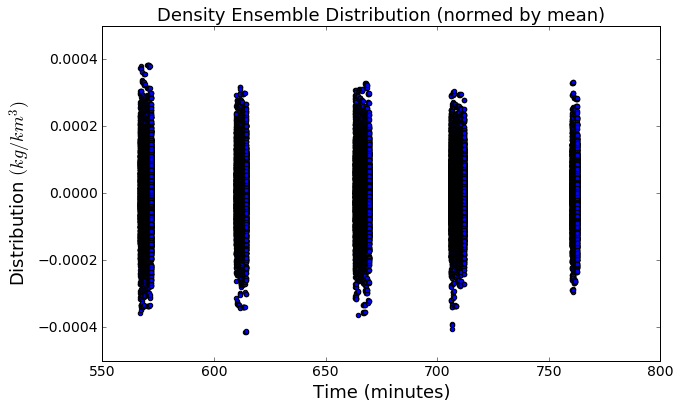

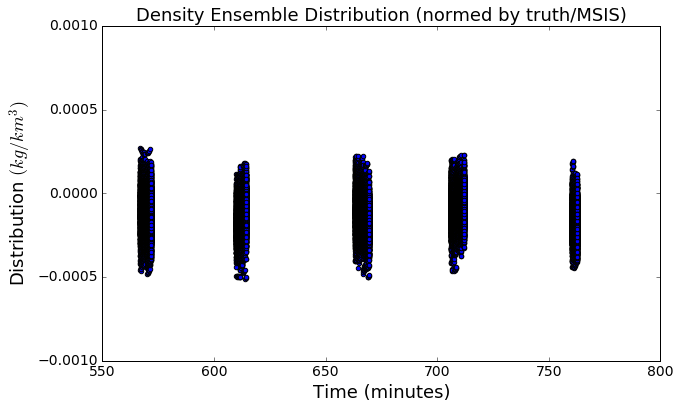

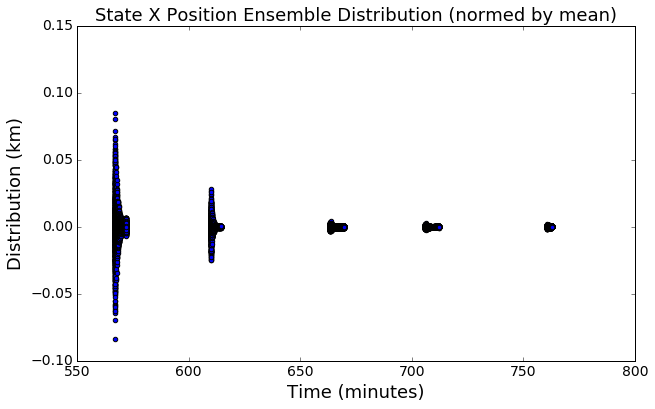

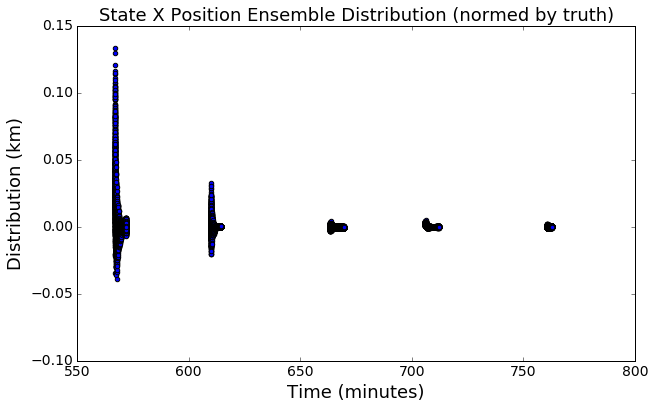

In [33]:

times = measurement_array[:stop_index, 0]/(60)

time_str = 'Time (minutes)'

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)

#"""
#calculate the normed density distribution by subtracting the mean of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_mean = np.mean(density_distribution[:,:stop_index], axis=0).reshape(1, stop_index)

density_distribution_mean_tiled = np.tile(density_distribution_mean, (1, num_of_ensembles))
density_distribution_mean_tiled = density_distribution_mean_tiled.reshape(num_of_ensembles, stop_index)

density_distribution_normed = density_distribution[:, :stop_index] - density_distribution_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-.5e-3, .5e-3)
plt.title('Density Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed density distribution by subtracting the truth of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_truth = density_MSIS_array[:stop_index].reshape(1, stop_index)
density_distribution_normed = density_distribution[:, :stop_index] - \
                    np.tile(density_distribution_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-1e-3, 1e-3)
plt.title('Density Ensemble Distribution (normed by truth/MSIS)', fontsize=18)
plt.show()
#"""

#calculate the normed X pos distribution by subtracting the mean of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos = X_distribution[0,:,:stop_index]
X_distribution_Xpos_mean = np.mean(X_distribution_Xpos, axis=0).reshape(1, stop_index)
X_distribution_Xpos_mean_tiled = np.tile(X_distribution_Xpos_mean, (1, num_of_ensembles))
X_distribution_Xpos_mean_tiled = X_distribution_Xpos_mean_tiled.reshape(num_of_ensembles, stop_index)
X_distribution_Xpos_diff = X_distribution_Xpos - X_distribution_Xpos_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_X, X_distribution_Xpos_diff.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4,1e-4)
plt.title('State X Position Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed X pos distribution by subtracting the truth of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos_truth = truth_xyz[:stop_index, 0].reshape(1, stop_index)
X_distribution_Xpos_truth_normed = X_distribution_Xpos - np.tile(X_distribution_Xpos_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, X_distribution_Xpos_truth_normed.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4, 1e-4)
plt.title('State X Position Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()



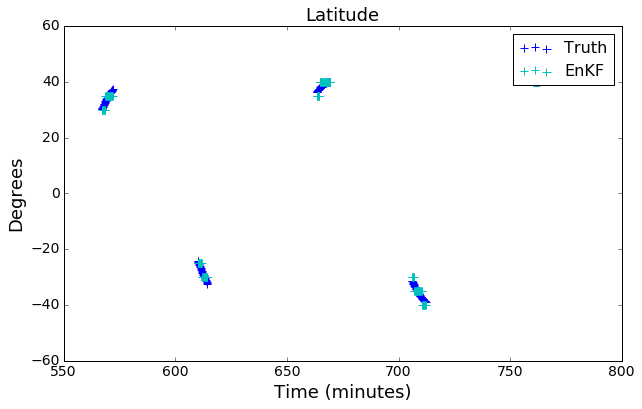

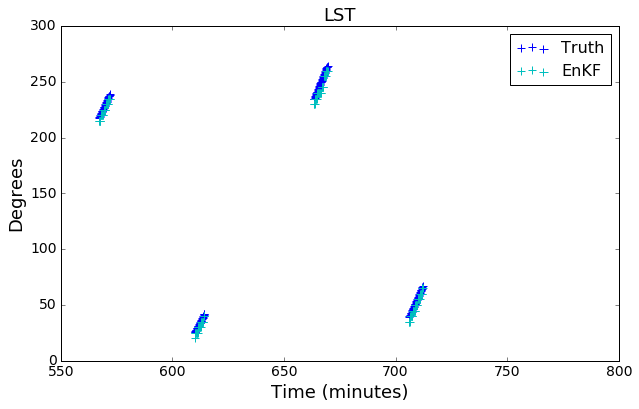

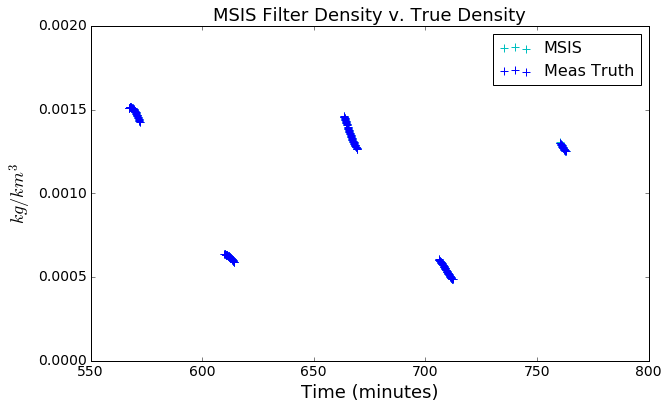

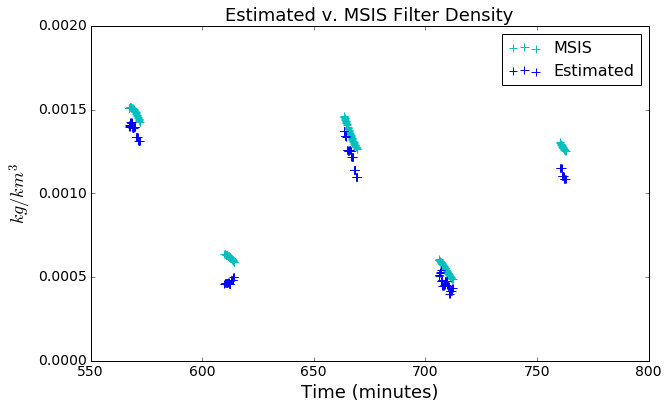

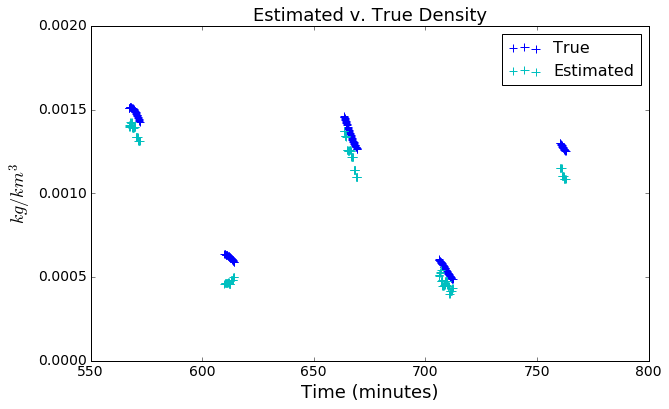

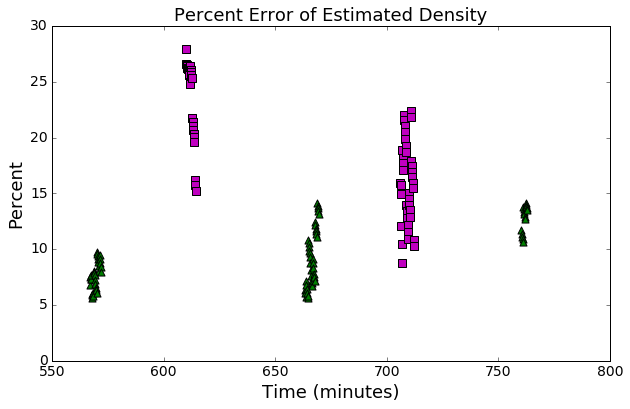

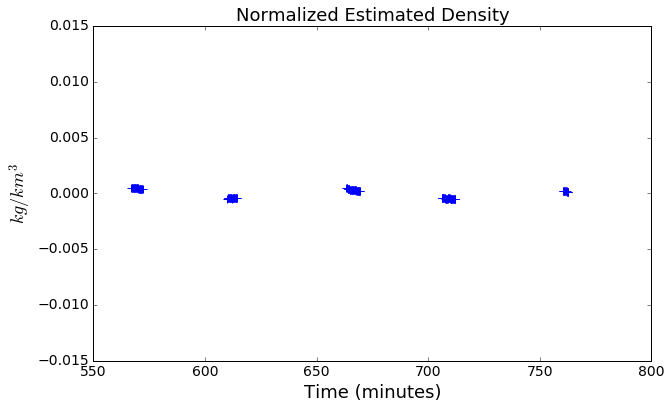

In [39]:


time_str = 'Time (minutes)'


times = measurement_array[:stop_index, 0]/(60)

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)


indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]


fig_lat = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 0]), s=70, c='b',marker='+')
plt.scatter(times, np.degrees(lat_lst_array[0,:stop_index]), s=70, c='c',marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Latitude', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()



fig_LST = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 1]), s=70, c='b', marker='+')
plt.scatter(times, np.degrees(lat_lst_array[1,:stop_index]), s=70, c='c', marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('LST', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('MSIS Filter Density v. True Density', fontsize=18)
legend_names = ['MSIS', 'Meas Truth']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, 6], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. MSIS Filter Density', fontsize=18)
legend_names = ['MSIS', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()




fig_density_comparison = plt.figure()
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, 6], s=70, c='c', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. True Density', fontsize=18)
legend_names = ['True', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()



perc_error = 100 * np.absolute(X_mean_updated_list_EnKF[:stop_index, 6] - true_density_array[:stop_index])/true_density_array[:stop_index]

fig_percent = plt.figure()
plt.scatter(times[indices_1], perc_error[indices_1], s=50, c='m', marker='s')
plt.scatter(times[indices_2], perc_error[indices_2], s=50, c='g', marker='^')
plt.scatter(times[indices_3], perc_error[indices_3], s=50, c='r', marker='D')
plt.scatter(times[indices_4], perc_error[indices_4], s=50, c='k', marker='o')
#plt.ylim([-1e-11,1e-11])
plt.ylabel('Percent', fontsize=18)
legend_names = ['Station 1', 'Station 2', 'Station 3', 'Station 4']
#plt.legend(legend_names, fontsize=10)
plt.xlabel(time_str, fontsize=18)
plt.title('Percent Error of Estimated Density', fontsize=18)
plt.show()



mean = np.mean(X_mean_updated_list_EnKF[:stop_index, 6])
est_density_array_normalized = X_mean_updated_list_EnKF[:stop_index, 6] - mean

fig_est = plt.figure()
plt.scatter(times, est_density_array_normalized[:stop_index], s=70, c='b', marker='+')
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Normalized Estimated Density', fontsize=18)
plt.show()



if saveFig_bool:
    fig_lat.savefig('Figures/latitude.png')
    fig_LST.savefig('Figures/LST.png')
    fig_density_comparison.savefig('Figures/density_comparison.png')
    fig_percent.savefig('Figures/percent.png')
    fig_est.savefig('Figures/est_density.png')


[]


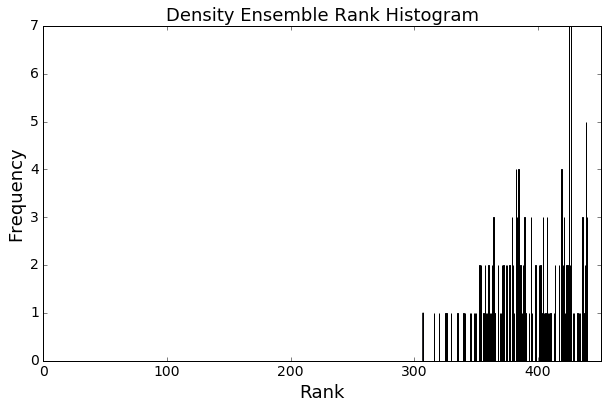

In [35]:
# Rank Histograms


#Density

rank_array = np.zeros((stop_index, 1))

for ii in range(stop_index):
    
    new_array = np.append(density_distribution[:, ii], density_MSIS_array[ii])
    
    rank = scipy.stats.rankdata(new_array, method='min')[-1]
    
    rank_array[ii] = rank
    
indices = np.where(rank_array != 450)[0]
indices1 = np.where(rank_array == 450)[0]
print(times[indices1])


fig_rank_hist = plt.figure()
plt.hist(rank_array, bins=451)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Rank', fontsize=18)
plt.title('Density Ensemble Rank Histogram', fontsize=18)
plt.xlim([0,451])
plt.show()

#fig_rank_hist.savefig('Figures/rank_hist.png')




In [55]:
def calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R, meas_type, stop_index, saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range pre-fit Residuals'
    save_fig_1 = 'prefit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate pre-fit Residuals'
    save_fig_2 = 'prefit_rangeRate.png'
    pre_fit_list_new = copy.deepcopy(pre_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        pre_fit_list_new[:, 0] = np.degrees(pre_fit_list[:, 0])
        pre_fit_list_new[:, 1] = np.degrees(pre_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth pre-fit Residuals'
        save_fig_1 = 'prefit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation pre-fit Residuals'
        save_fig_2 = 'prefit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]

    
    
    #pre-fit
    print('pre-fit RMS:')
    pre_fit_1_list_4RMS = pre_fit_list_new[:, 0]
    prefit_1_rms = np.sqrt(np.mean(np.square(pre_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % prefit_1_rms, unit_1)

    pre_fit_2_list_4RMS = pre_fit_list_new[:, 1]
    prefit_2_rms = np.sqrt(np.mean(np.square(pre_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % prefit_2_rms, unit_2)
    
    if meas_type == 3:
        pre_fit_3_list_4RMS = pre_fit_list_new[:, 2]
        prefit_3_rms = np.sqrt(np.mean(np.square(pre_fit_3_list_4RMS)))
        print('Range =', "%.3f" % prefit_3_rms, 'km')
    
    
    covar_env_upper1 = np.degrees(abs(prefit_bounds_list[:stop_index, 0]))*3
    covar_env_upper2 = np.degrees(abs(prefit_bounds_list[:stop_index, 1]))*3

   
    #pre-fit Residuals
    fig_preFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_preFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = abs(prefit_bounds_list[:stop_index, 2])*3
        
        fig_preFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range pre-fit Residuals', fontsize=18)
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('prefit_range.png')
    
    if saveFig_bool:
        fig_preFit_az.savefig('Figures/preFit_az.png')
        fig_preFit_el.savefig('Figures/preFit_el.png')
        fig_preFit_range.savefig('Figures/preFit_range.png')
        
        
def calc_display_results(post_fit_list, measurement_array, R, meas_type, stop_index, saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range Post-fit Residuals'
    save_fig_1 = 'postfit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate Post-fit Residuals'
    save_fig_2 = 'postfit_rangeRate.png'
    post_fit_list_new = copy.deepcopy(post_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        post_fit_list_new[:, 0] = np.degrees(post_fit_list[:, 0])
        post_fit_list_new[:, 1] = np.degrees(post_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth Post-fit Residuals'
        save_fig_1 = 'postfit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation Post-fit Residuals'
        save_fig_2 = 'postfit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]

    
    
    #Post-fit
    print('Post-fit RMS:')
    post_fit_1_list_4RMS = post_fit_list_new[:, 0]
    postfit_1_rms = np.sqrt(np.mean(np.square(post_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % postfit_1_rms, unit_1)

    post_fit_2_list_4RMS = post_fit_list_new[:, 1]
    postfit_2_rms = np.sqrt(np.mean(np.square(post_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % postfit_2_rms, unit_2)
    
    if meas_type == 3:
        post_fit_3_list_4RMS = post_fit_list_new[:, 2]
        postfit_3_rms = np.sqrt(np.mean(np.square(post_fit_3_list_4RMS)))
        print('Range =', "%.5f" % postfit_3_rms, 'km')
    
    
    covar_env_upper1 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[0, 0])))*3
    covar_env_upper2 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[1, 1])))*3

   
    #Post-fit Residuals
    fig_postFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_postFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = np.ones((stop_index)) * np.sqrt(abs(R[2, 2]))*3
        
        fig_postFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], post_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], post_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], post_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], post_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range Post-fit Residuals', fontsize=18)
        legend_names = ['Station 1', 'Station 2']
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('postfit_range.png')
    
    if saveFig_bool:
        fig_postFit_az.savefig('Figures/postFit_az.png')
        fig_postFit_el.savefig('Figures/postFit_el.png')
        fig_postFit_range.savefig('Figures/postFit_range.png')
        
    
    
def plot_error_covar_xref(P_list, x_ref_updated_list, obs_data_truth, density_truth, x_range, y_range, \
                          z_range, xv_range, yv_range, zv_range, measurement_array, time, stop_index, saveFig_bool, time_str):
    
    #Compare to the Truth Data : Estimation Errors------

    times = time[:stop_index]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]
    
    density_covar_env_upper = np.sqrt(abs(P_list[:stop_index, -1, -1]))*3
    density_covar_env_lower = -density_covar_env_upper
    density_error = x_ref_updated_list[:stop_index,-1] - density_truth[:stop_index]
    
    x_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 0, 0]))*3
    x_covar_env_lower = -x_covar_env_upper
    x_error = x_ref_updated_list[:stop_index,0] - obs_data_truth[:stop_index, 0]
    
    y_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 1, 1]))*3
    y_covar_env_lower = -y_covar_env_upper
    y_error = x_ref_updated_list[:stop_index,1] - obs_data_truth[:stop_index, 1]
    
    z_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 2, 2]))*3
    z_covar_env_lower = -z_covar_env_upper
    z_error = x_ref_updated_list[:stop_index,2] - obs_data_truth[:stop_index, 2]
    
    #error_pos_norm = np.sqrt(x_error**2 + y_error**2 + z_error**2)
    error_density_rms_3D = np.sqrt(np.mean(np.square(density_error)))
    print('Density RMS =', "%.5f" % error_density_rms_3D, r'$(kg/km^3)$')
    
    print('Position RMS:')
    error_x_pos_rms_3D = np.sqrt(np.mean(np.square(x_error)))
    print('X =', "%.4f" % error_x_pos_rms_3D, 'km')
    
    error_y_pos_rms_3D = np.sqrt(np.mean(np.square(y_error)))
    print('Y =', "%.4f" % error_y_pos_rms_3D, 'km')
    
    error_z_pos_rms_3D = np.sqrt(np.mean(np.square(z_error)))
    print('Z =', "%.4f" % error_z_pos_rms_3D, 'km')
    
    pos_rms = np.sqrt(error_x_pos_rms_3D**2 + error_y_pos_rms_3D**2 + error_z_pos_rms_3D**2)
    print('Overall =', "%.4f" % pos_rms, 'km')
    
    
    #Density
    fig_dens = plt.figure()
    plt.plot(times, density_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, density_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], density_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], density_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], density_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], density_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel(r'$(kg/km^3)$', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    legend_names = ['Station 1', 'Station 2']
    plt.legend(legend_names, fontsize=10)
    plt.title('Reduced Rank EnKF Density Error & Covariance Envelope', fontsize=18)
    #plt.ylim([-x_range,x_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    

    #x Position
    fig_xpos = plt.figure()
    plt.plot(times, x_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, x_covar_env_lower, label='_nolegend_', c='g')
    
    plt.scatter(times[indices_1], x_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], x_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], x_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], x_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('Reduced Rank EnKF X Position Error & Covariance Envelope', fontsize=18)
    plt.ylim([-x_range,x_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()

    #y Position 
    fig_ypos = plt.figure()
    plt.plot(times, y_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, y_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], y_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], y_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], y_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], y_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('EnKF Y Position Error & Covariance Envelope', fontsize=18)
    plt.ylim([-y_range,y_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    #fig.savefig('y_pos_error.png')

    #z Position
    fig_zpos = plt.figure()
    plt.plot(times, z_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, z_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], z_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], z_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], z_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], z_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('EnKF Z Position Error & Covariance Envelope', fontsize=18)
    plt.ylim([-z_range,z_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    
    #x Velocity
    x_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 3, 3]))*3
    x_dot_covar_env_lower = -np.sqrt(abs(P_list[:stop_index, 3, 3]))*3
    x_vel_error = x_ref_updated_list[:stop_index,3] - obs_data_truth[:stop_index, 3]

    fig_xvel = plt.figure()
    plt.plot(times, x_dot_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, x_dot_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], x_vel_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], x_vel_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], x_vel_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], x_vel_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km/second', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('EnKF X Velocity Error & Covariance Envelope', fontsize=18)
    plt.ylim([-xv_range,xv_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    #fig.savefig('x_vel_error.png')

    #y Velocity
    y_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 4, 4]))*3
    y_dot_covar_env_lower = -np.sqrt(abs(P_list[:stop_index, 4, 4]))*3
    y_vel_error = x_ref_updated_list[:stop_index,4] - obs_data_truth[:stop_index, 4]

    fig_yvel = plt.figure()
    plt.plot(times, y_dot_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, y_dot_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], y_vel_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], y_vel_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], y_vel_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], y_vel_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km/second', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('EnKF Y Velocity Error & Covariance Envelope', fontsize=18)
    plt.ylim([-yv_range,yv_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()

    #z Velocity
    z_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, 5, 5]))*3
    z_dot_covar_env_lower = -np.sqrt(abs(P_list[:stop_index, 5, 5]))*3
    z_vel_error = x_ref_updated_list[:stop_index,5] - obs_data_truth[:stop_index, 5]

    fig_zvel = plt.figure()
    plt.plot(times, z_dot_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, z_dot_covar_env_lower, label='_nolegend_', c='g') 
    plt.scatter(times[indices_1], z_vel_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], z_vel_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], z_vel_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], z_vel_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel('km/second', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    plt.title('EnKF Z Velocity Error & Covariance Envelope', fontsize=18)
    plt.ylim([-zv_range,zv_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    
    
    print('Velocity RMS:')
    error_x_vel_rms_3D = np.sqrt(np.mean(np.square(x_vel_error)))
    print('X =', "%.6f" % error_x_vel_rms_3D, 'km/second')
    
    error_y_vel_rms_3D = np.sqrt(np.mean(np.square(y_vel_error)))
    print('Y =', "%.6f" % error_y_vel_rms_3D, 'km/second')
    
    error_z_vel_rms_3D = np.sqrt(np.mean(np.square(z_vel_error)))
    print('Z =', "%.6f" % error_z_vel_rms_3D, 'km/second')
    
    vel_rms = np.sqrt(error_x_vel_rms_3D**2 + error_y_vel_rms_3D**2 + error_z_vel_rms_3D**2)
    print('Overall =', "%.6f" % vel_rms, 'km/s')

    
    if saveFig_bool:
        fig_dens.savefig('Figures/dens_error.png')
        fig_xpos.savefig('Figures/x_pos_error.png')
        fig_ypos.savefig('Figures/y_pos_error.png')
        fig_zpos.savefig('Figures/z_pos_error.png')
        fig_xvel.savefig('Figures/x_vel_error.png')
        fig_yvel.savefig('Figures/y_vel_error.png')
        fig_zvel.savefig('Figures/z_vel_error.png')
    
        

pre-fit RMS:
Azimuth = 0.0014 degrees
Elevation = 0.0015 degrees
Range = 0.003 km


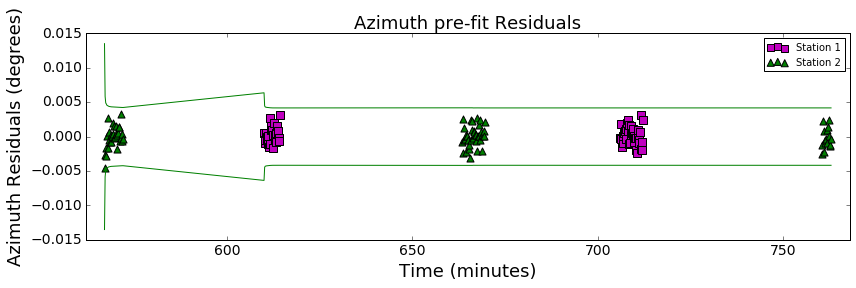

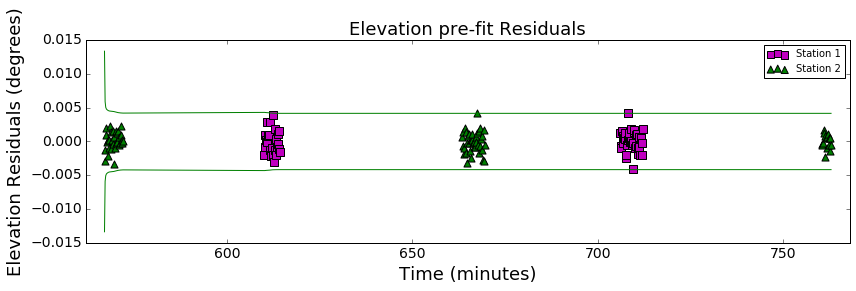

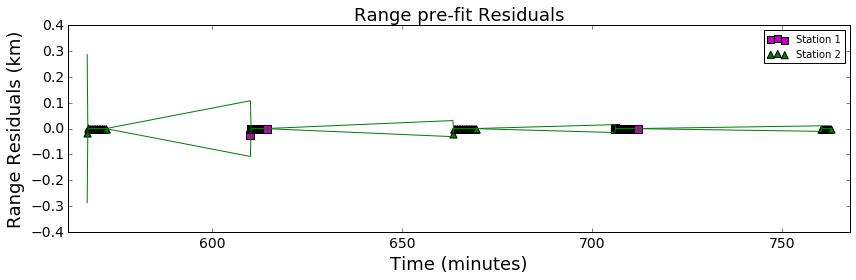

Post-fit RMS:
Azimuth = 0.0013 degrees
Elevation = 0.0014 degrees
Range = 0.00002 km


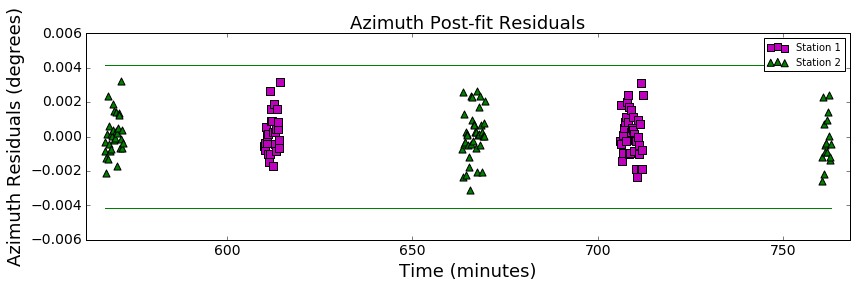

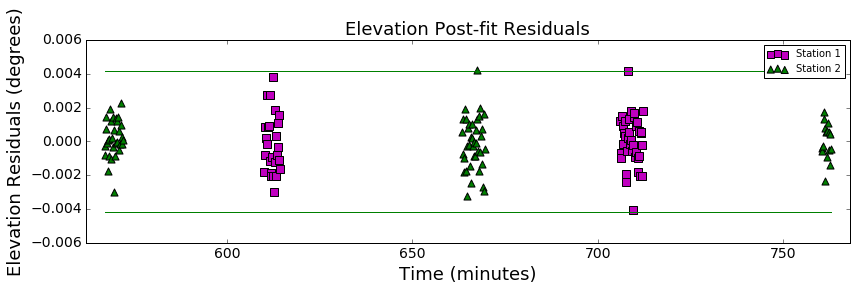

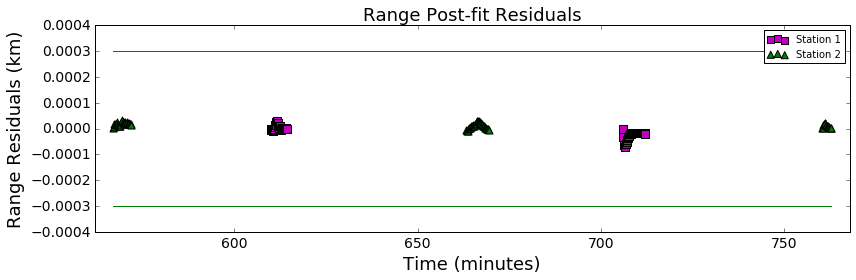

Density RMS = 0.00013 $(kg/km^3)$
Position RMS:
X = 0.0046 km
Y = 0.0024 km
Z = 0.0024 km
Overall = 0.0057 km


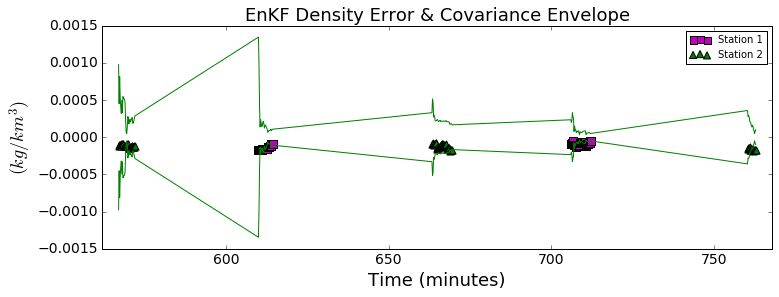

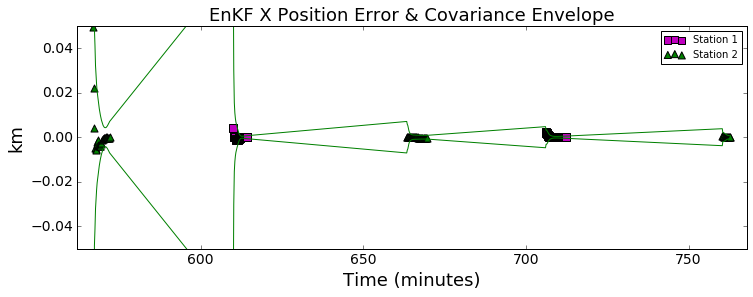

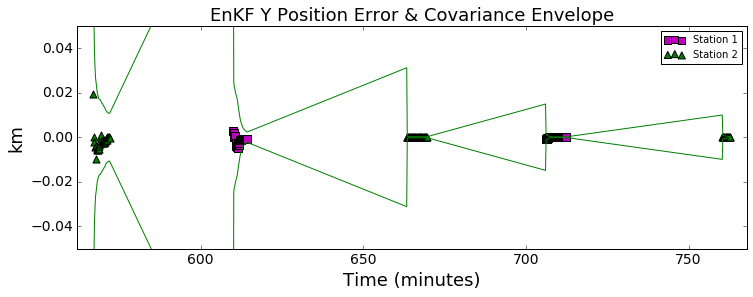

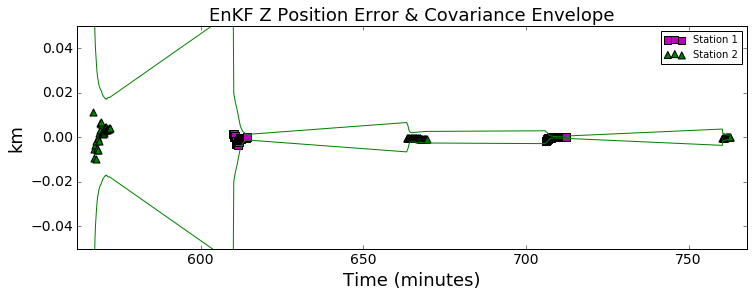

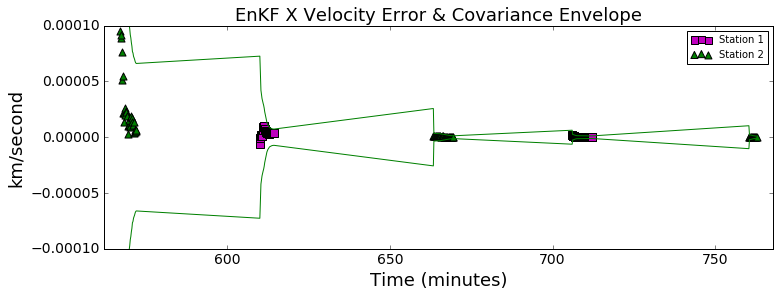

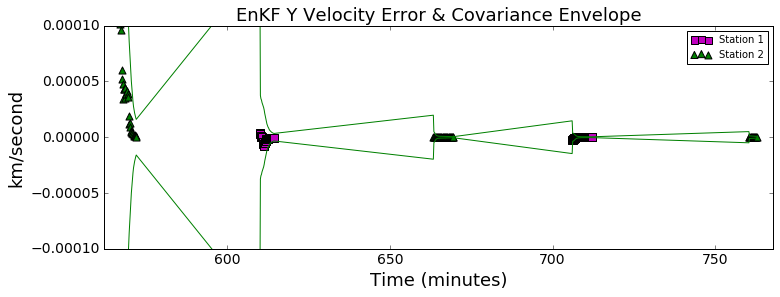

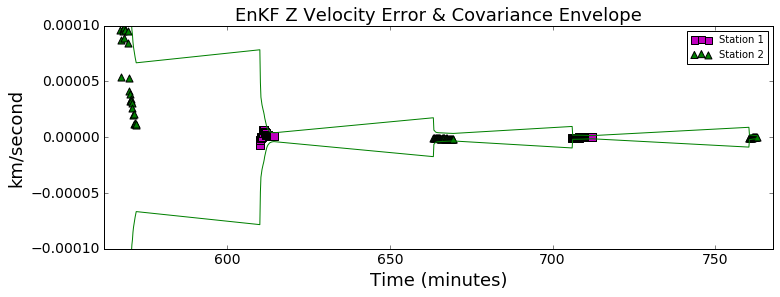

Velocity RMS:
X = 0.000017 km/second
Y = 0.000021 km/second
Z = 0.000033 km/second
Overall = 0.000043 km/s


In [54]:

#Generate Plots for Analysis

x_range = .05
y_range = .05
z_range = .05

xv_range = 1e-4
yv_range = 1e-4
zv_range = 1e-4

times = measurement_array[:, 0]


calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R, meas_type, stop_index, saveFig_bool, time_str)


calc_display_results(post_fit_list_EnKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)


plot_error_covar_xref(P_list_EnKF, X_mean_updated_list_EnKF, \
                      truth_xyz, true_density_array, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str)


In [38]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[ 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95 134 1

In [26]:
print(measurement_array[10:, 0])

[ 34120.  34130.  34140.  34150.  34160.  34170.  34180.  34190.  34200.
  34210.  34220.  34230.  34240.  34250.  34260.  34270.  34280.  34290.
  34300.  34310.  34320.  36600.  36610.  36620.  36630.  36640.  36650.
  36660.  36670.  36680.  36690.  36700.  36710.  36720.  36730.  36740.
  36750.  36760.  36770.  36780.  36790.  36800.  36810.  36820.  36830.
  36840.  36850.  36860.  39800.  39810.  39820.  39830.  39840.  39850.
  39860.  39870.  39880.  39890.  39900.  39910.  39920.  39930.  39940.
  39950.  39960.  39970.  39980.  39990.  40000.  40010.  40020.  40030.
  40040.  40050.  40060.  40070.  40080.  40090.  40100.  40110.  40120.
  40130.  40140.  40150.  40160.  40170.  42360.  42370.  42380.  42390.
  42400.  42410.  42420.  42430.  42440.  42450.  42460.  42470.  42480.
  42490.  42500.  42510.  42520.  42530.  42540.  42550.  42560.  42570.
  42580.  42590.  42600.  42610.  42620.  42630.  42640.  42650.  42660.
  42670.  42680.  42690.  42700.  42710.  42720.  4

In [40]:
times = measurement_array[:stop_index,0]/(60)
print(times)

[ 567.                 567.166666666666629  567.333333333333371  567.5
  567.666666666666629  567.833333333333371  568.                 568.166666666666629
  568.333333333333371  568.5                568.666666666666629
  568.833333333333371  569.                 569.166666666666629
  569.333333333333371  569.5                569.666666666666629
  569.833333333333371  570.                 570.166666666666629
  570.333333333333371  570.5                570.666666666666629
  570.833333333333371  571.                 571.166666666666629
  571.333333333333371  571.5                571.666666666666629
  571.833333333333371  572.                 610.                 610.166666666666629
  610.333333333333371  610.5                610.666666666666629
  610.833333333333371  611.                 611.166666666666629
  611.333333333333371  611.5                611.666666666666629
  611.833333333333371  612.                 612.166666666666629
  612.333333333333371  612.5                612.6666666

In [28]:
perc_error = 100 * np.absolute(X_mean_updated_list_EnKF[:stop_index, 6] - true_density_array[:stop_index])/true_density_array[:stop_index]


In [29]:
np.max(ensembles_of_density_grid)

In [30]:
np.min(ensembles_of_density_grid)